In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from konlpy.tag import Mecab

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

In [84]:
word_data = pd.read_table('ratings_train.txt')

In [85]:
word_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [86]:
word_data.drop_duplicates(subset='document', inplace = True)

word_data['document'] = word_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
word_data['document'] = word_data['document'].str.replace('^ +','')
word_data['document'].replace('',np.nan, inplace = True)

word_data = word_data.dropna(axis = 0)

In [87]:
corpus = word_data['document'].values.copy()

In [88]:
for i in range(5):
    print(i,corpus[i])

0 아 더빙 진짜 짜증나네요 목소리
1 흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2 너무재밓었다그래서보는것을추천한다
3 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4 사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다


## konlpy 한국어 분석기

In [89]:
tokenizer  = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

#### 형대소 단위 분석기 사용 예시

In [90]:
print(corpus[0])

아 더빙 진짜 짜증나네요 목소리


In [91]:
morphs = tokenizer.morphs(corpus[0])
print(morphs)

['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']


In [92]:
sentence_data = []
words = []
for sentence in tqdm(corpus):

    temp_x = tokenizer.morphs(sentence)

    temp_x = [w for w in temp_x if len(w)>=2]
    
    sentence_data.append(temp_x)
    words.extend(temp_x)

100%|███████████████████████████████████████████████████████████████████████| 145393/145393 [00:07<00:00, 20658.50it/s]


In [99]:
word_dic ={}
for sentence in sentence_data:
    for w in sentence:
        word_dic[w] = word_dic.get(w,0)+1

In [171]:
vocab = sorted(word_dic,key =word_dic.get,reverse = True)

In [172]:
word_dic ={w:word_dic[w] for w in vocab}

In [173]:
print(f'단어의 종류 수 : {len(vocab)}')

단어의 종류 수 : 48022


In [174]:
word_counts = np.array(list(word_dic.values()))

In [175]:
minimum_counts_idx = np.where(word_counts>20)[0][-1]

In [176]:
print(f'{minimum_counts_idx} 번째 단어 등장횟수 : {word_dic[idx2word[minimum_counts_idx]]}')

4886 번째 단어 등장횟수 : 21


In [177]:
vocab=vocab[:minimum_counts_idx]

In [178]:
print(f'단어의 종류 수 : {len(vocab)}')

단어의 종류 수 : 4886


In [179]:
idx2word = ['<UNK>']+vocab

In [180]:
word2idx ={idx2word[i]:i for i ,_ in enumerate(idx2word)}

### Skipgram

In [184]:
def skipgram(sentence, i, window_size = 2):
    iword = sentence[i]
    left = sentence[max(i-window_size,0):i]
    right = sentence[i+1:i+1+window_size]
    
    return iword,["<UNK>" for _ in range(window_size - len(left))] + left + right + ["<UNK>" for _ in range(window_size - len(right))]

In [185]:
data = []

for senten in sentence_data:
    
    for i in range(len(senten)):
        iword, owords = skipgram(senten, i)
        try:
            data.append((word2idx[iword], [word2idx[oword] for oword in owords]))
        except:
            pass

In [186]:
train_data = []
for x,y_window in data:
    for y in y_window:
        train_data.append((x,y))

In [187]:
class Dataset_skipgram(Dataset):
    def __init__(self,data,vocab_size ):
        self.data = torch.tensor(data, device = 'cuda')
        self.temp_x = self.data[:,0]
        
        i  = [[i for i in range(len(self.temp_x))],self.temp_x]
        v = [1] * len(self.temp_x)
        
        self.x = torch.sparse_coo_tensor(i, v, (len(self.temp_x), vocab_size), device = 'cuda')    
        self.y = self.data[:,1]
        
        self.vocab_size = vocab_size
        
    def __getitem__(self,idx):
        x = self.x[idx].to_dense()
        y = self.y[idx]
        return x,y
    
    def __len__(self):
        return len(self.x)

In [188]:
vocab_size = len(idx2word)

In [190]:
train_dataset =Dataset_skipgram(train_data,vocab_size)

In [192]:
train_dataloader = DataLoader(train_dataset,batch_size=1024,shuffle= True)

In [194]:
class skipgrams(nn.Module):
    def __init__(self,dimension,embedding):
        super().__init__()
        
        self.dimension = dimension
        self.embedding = embedding
        
        
        self.embedding_layer = nn.Linear(self.dimension,self.embedding, bias = False)
        self.Softmax_Weight =nn.Linear(self.embedding,self.dimension, bias = False) 
        
    def forward(self,x):
        x= self.embedding_layer(x)
        x = self.Softmax_Weight(x)
        x = F.log_softmax(x,dim=1)
        return x

In [195]:
model = skipgrams(vocab_size,100)
model.to('cuda')

skipgrams(
  (embedding_layer): Linear(in_features=4887, out_features=100, bias=False)
  (Softmax_Weight): Linear(in_features=100, out_features=4887, bias=False)
)

In [196]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters() , lr =1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5,patience=30)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,1)


In [197]:
Epochs= 5000
losses = []
minimum_loss= 1000
step = 0

for epoch in range(1,Epochs+1):
    model.train()
    train_loss = 0
    for x_c,y_t in train_dataloader:
        x_c,y_t = x_c.to('cuda'), y_t.to('cuda')
        optimizer.zero_grad()
        pred = model(x_c.float())
        
        loss= criterion(pred,y_t)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss+= loss.item()
    train_loss/= len(train_dataloader)
    scheduler.step(train_loss)
    losses.append(train_loss)
    
    for param_group in optimizer.param_groups:
        learning_rate = param_group['lr']
    
    if minimum_loss > train_loss:
        minimum_loss = train_loss
        torch.save(model , './embedding_model.pth')
        step = 0
    else:
        step+=1
        
    if step >200:
        print(f'Trian early stopped at {epoch} Epochs.....')
        break
    
    if(epoch%10 ==0):
        print(epoch,train_loss , learning_rate,step)

10 8.258746147155762 0.001 0
20 7.069487476348877 0.001 0
30 5.771260166168213 0.001 0
40 5.16923885345459 0.001 0
50 4.896410274505615 0.001 0
60 4.6723979949951175 0.001 0
70 4.401917552947998 0.001 0
80 4.105810737609863 0.001 0
90 3.797668695449829 0.001 0
100 3.509118938446045 0.001 0
110 3.2504062175750734 0.001 0
120 3.0383257389068605 0.001 0
130 2.866903829574585 0.001 0
140 2.7221347808837892 0.001 0
150 2.607012891769409 0.001 0
160 2.518488550186157 0.001 0
170 2.4448646545410155 0.001 0
180 2.393982696533203 0.001 1
190 2.3423389434814452 0.001 0
200 2.306611204147339 0.001 0
210 2.2783098220825195 0.001 0
220 2.2581131935119627 0.001 1
230 2.2351069927215574 0.001 0
240 2.223213052749634 0.001 2
250 2.206768751144409 0.001 1
260 2.194999885559082 0.001 0
270 2.1907684803009033 0.001 2
280 2.1815622329711912 0.001 1
290 2.176317644119263 0.001 1
300 2.1674991130828856 0.001 0
310 2.1669790744781494 0.001 6
320 2.160719871520996 0.001 5
330 2.1561865329742433 0.001 0
340 2.

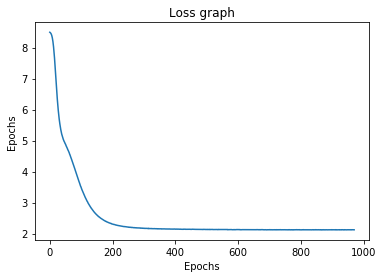

In [198]:
plt.figure()
plt.title('Loss graph')
plt.xlabel('Epochs')
plt.ylabel('Epochs')
plt.plot(range(epoch),losses)
plt.show()

In [400]:
emb_metrix = model.embedding_layer.weight.clone().detach().to('cpu').T

In [401]:
emb_metrix.shape

torch.Size([4887, 100])

In [299]:
from sklearn.manifold import TSNE

tsne = TSNE()


visualize_size = len(idx2word[:100])

embed_tsne = tsne.fit_transform(emb_metrix[:visualize_size, :])
embed_tsne_plot =pd.DataFrame(embed_tsne, columns =["x","y"])

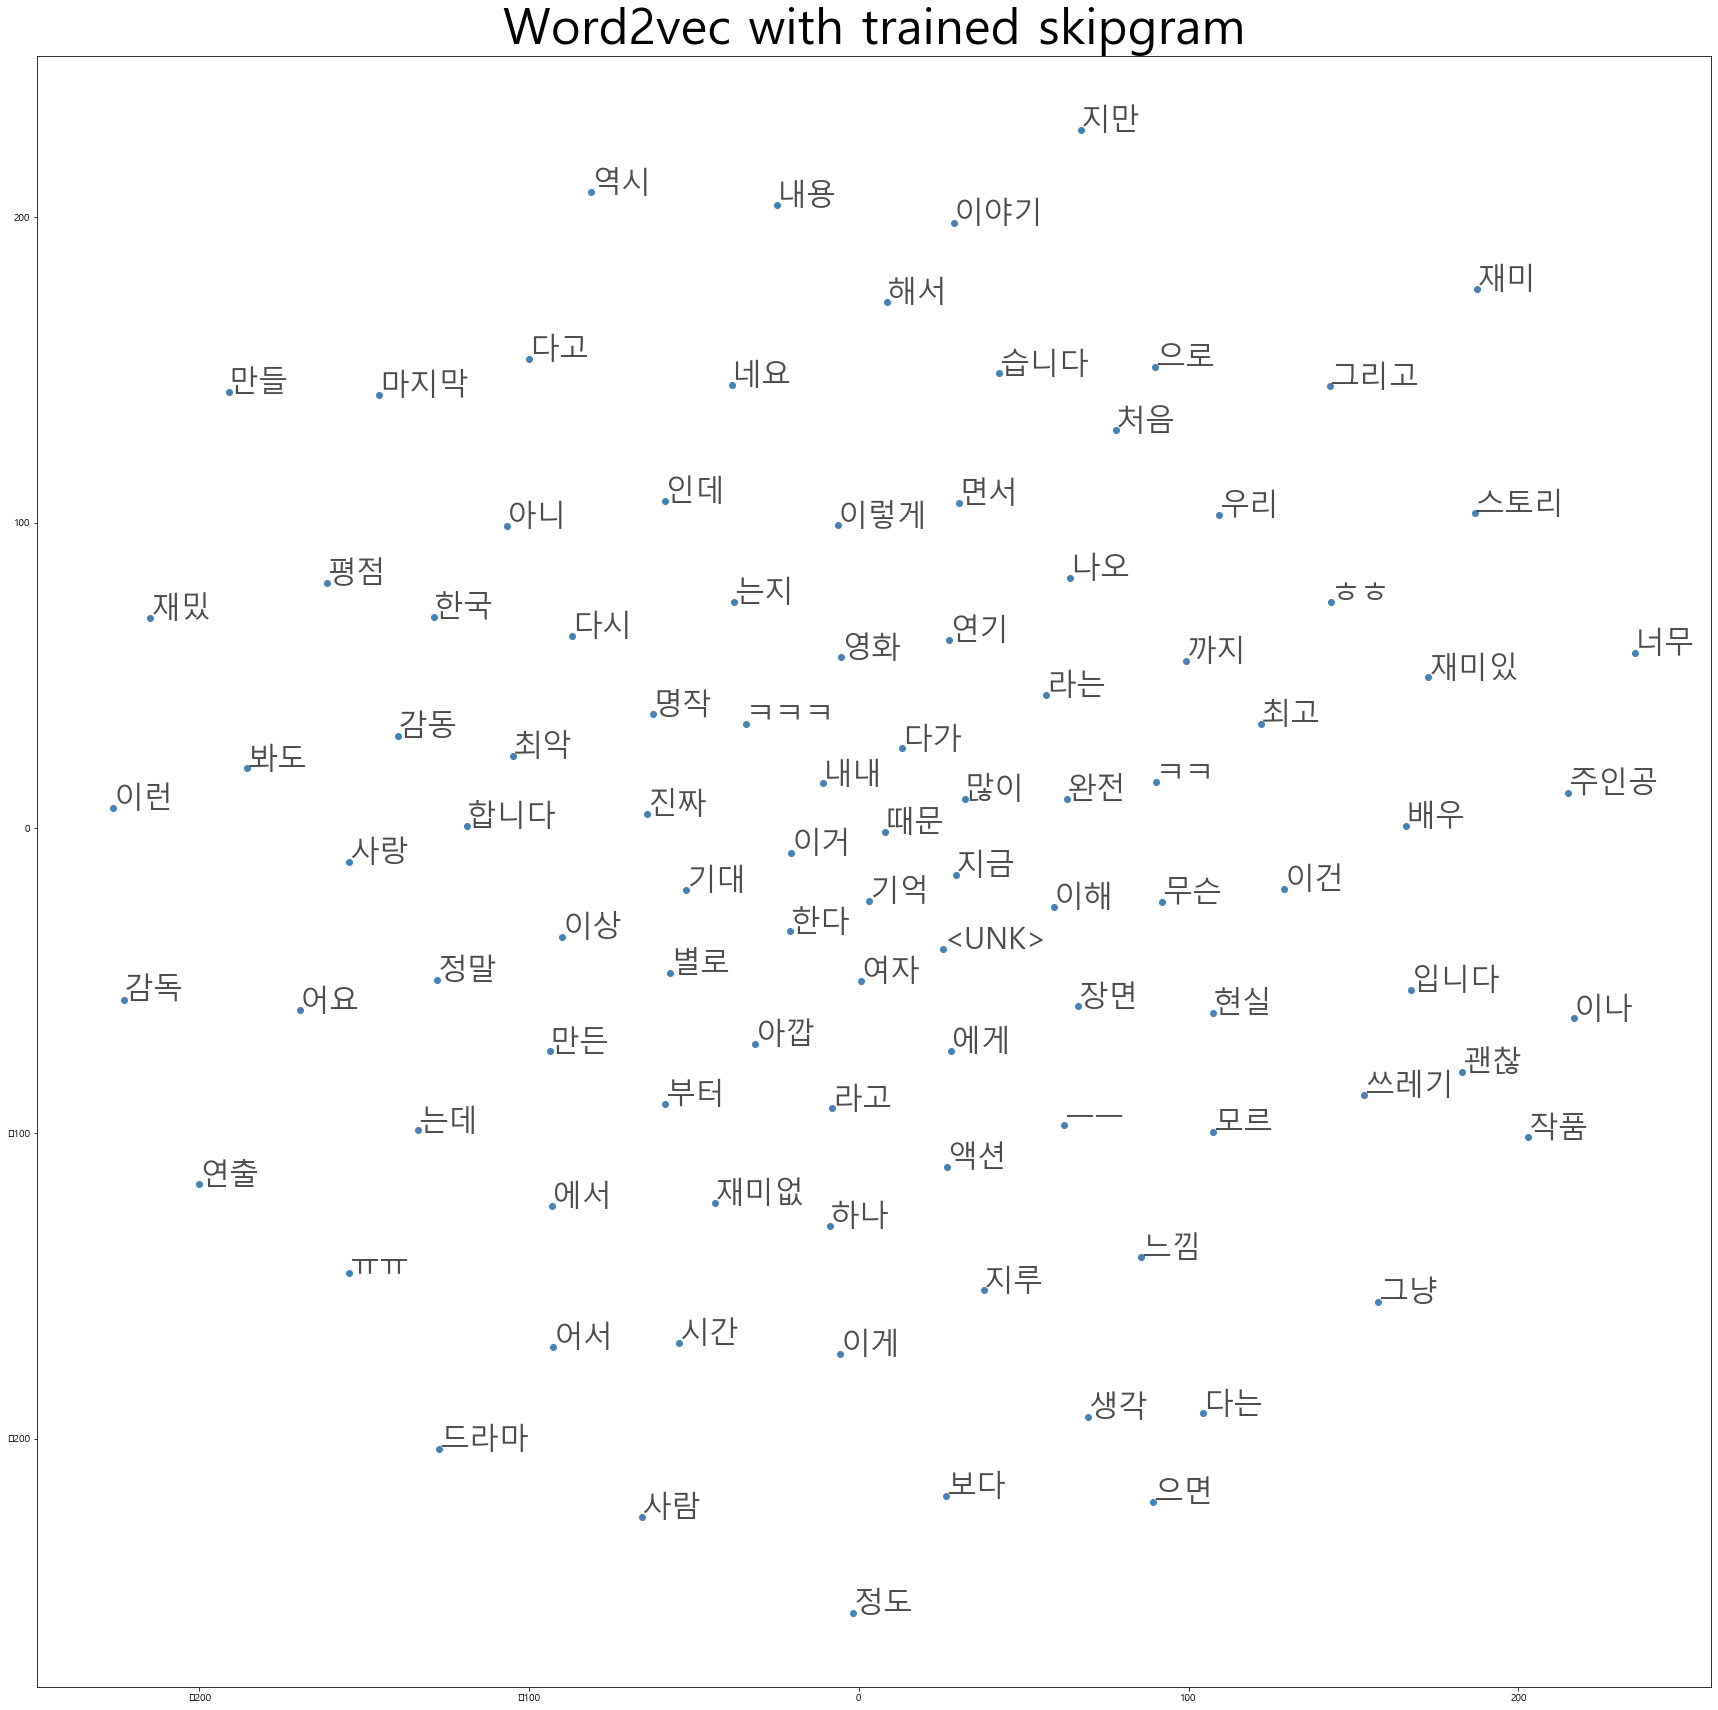

In [301]:
fig, ax = plt.subplots(figsize=(30, 30))
plt.title('Word2vec with trained skipgram',{'fontsize':50})
plt.rc('font', family='Malgun Gothic')
plt.scatter(embed_tsne_plot["x"],embed_tsne_plot["y"], color='steelblue' )
for idx in range(visualize_size):    
    plt.annotate(idx2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]),fontsize=30, alpha=0.7)
plt.show()

In [410]:
tsne = TSNE(3)

visualize_size = len(idx2word[:100])

embed_tsne = tsne.fit_transform(emb_metrix[:visualize_size, :])
embed_tsne_plot =pd.DataFrame(embed_tsne, columns =["x","y","z"])

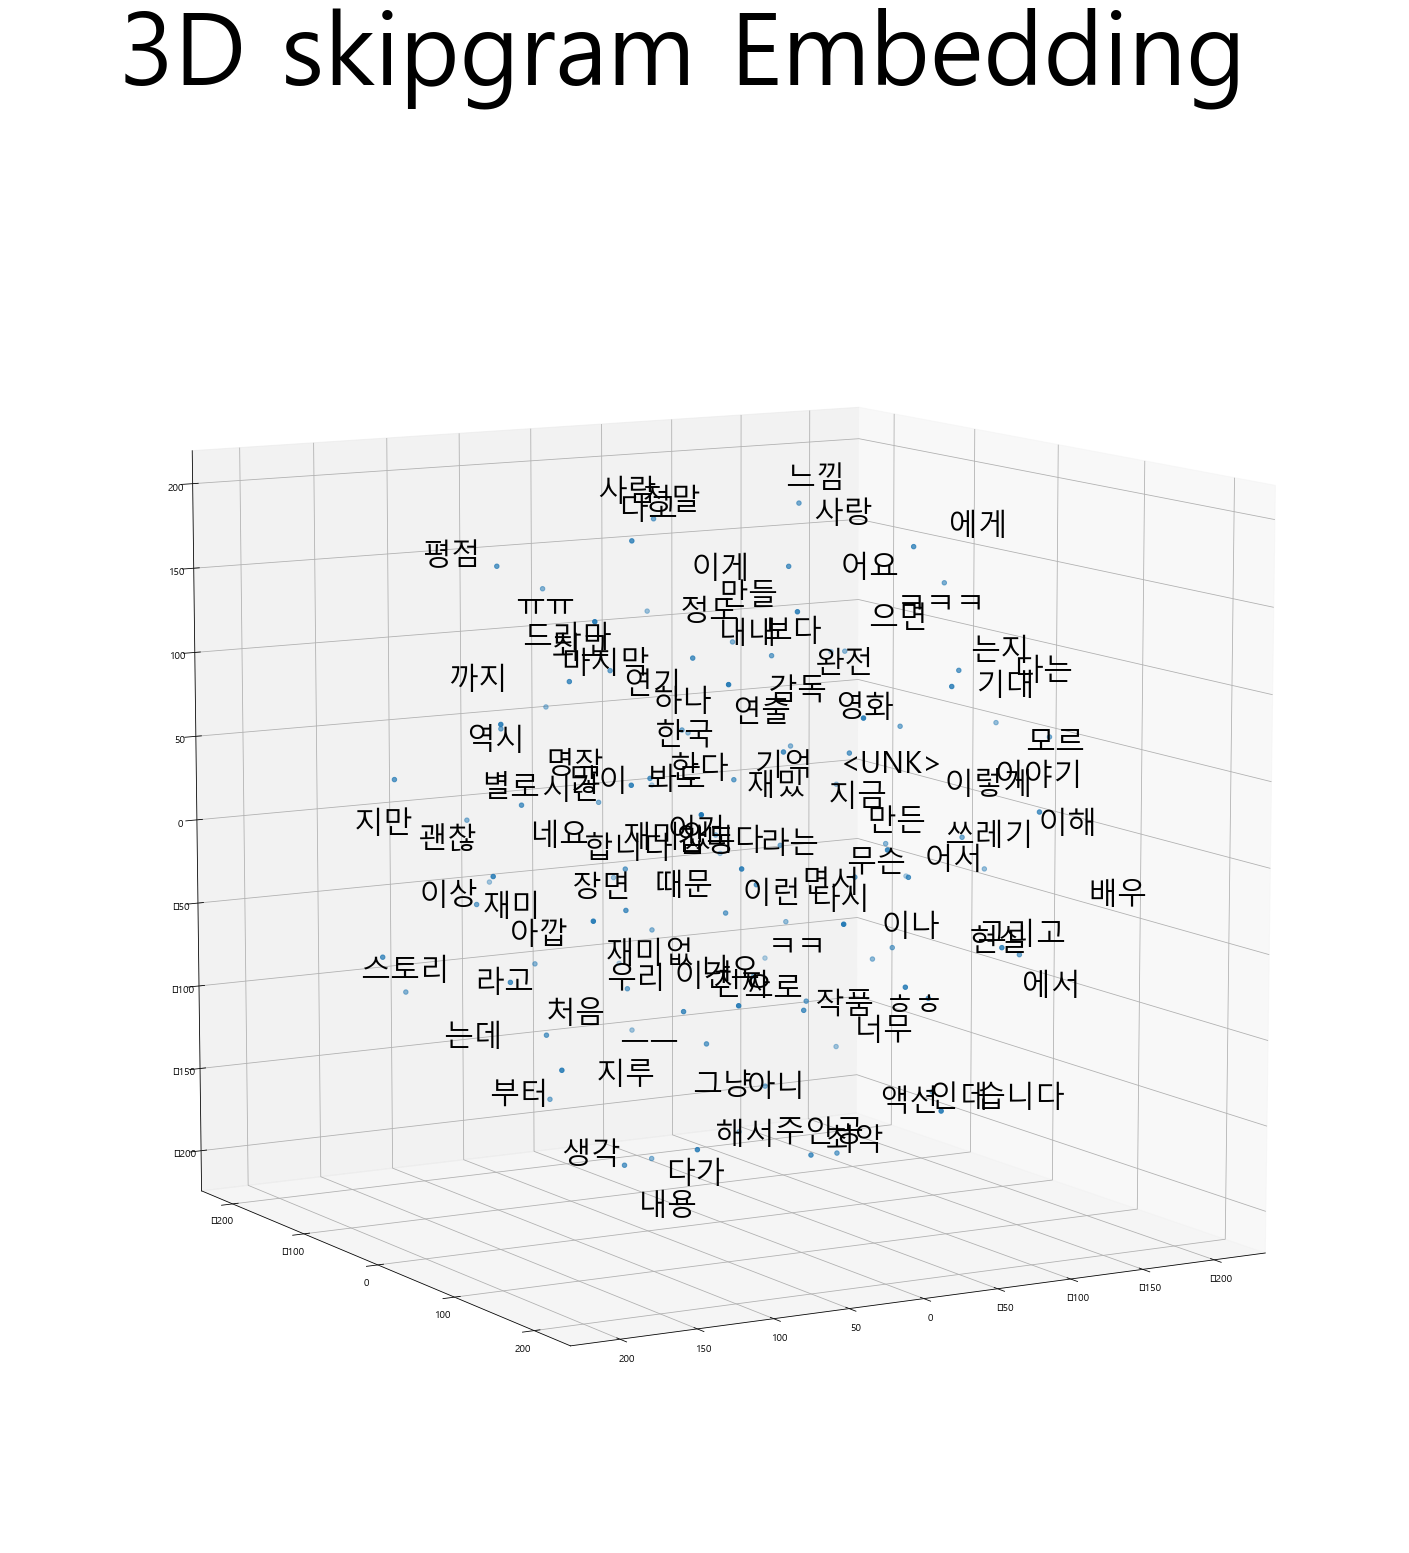

In [412]:
fig = plt.figure(figsize = [25,25])
ax = fig.gca(projection ='3d')
ax.scatter(x,y,z)

ax.view_init(10,60)
for idx, (xi, yi, zi) in enumerate(embed_tsne_plot.values):
    label = idx2word[idx]
    ax.text(xi, yi, zi, label,fontsize = 30)

plt.suptitle('3D skipgram Embedding',size = 100)
plt.show()

### Pretrained Word2vec FastText 사용하기

In [ ]:
from gensim import models

ko_model = models.fasttext.load_facebook_model('./fasttext_korean/cc.ko.300.bin.gz')
for w, sim in ko_model.wv.most_similar('파이썬'):
    print(f'{w}: {sim}')

In [211]:
from gensim import models

In [216]:
ko_model = models.fasttext.load_facebook_model('./fasttext_korean/cc.ko.300.bin.gz')

In [224]:
for w, sim in ko_model.wv.most_similar('파이썬'):
    print(f'{w}: {sim}')

Python: 0.5650615692138672
자이썬: 0.5624369382858276
레일스: 0.5598082542419434
파이썬을: 0.5595802068710327
언어용: 0.5288202166557312
파이썬의: 0.5250024795532227
프로그래밍: 0.5225088596343994
wxPython: 0.5222088694572449
파이썬이나: 0.5201171636581421
함수형: 0.5187377333641052


In [238]:
print(ko_model.wv.similarity("코딩", '파이썬'))
print(ko_model.wv.similarity("파이썬", '자바'))
print(ko_model.wv.similarity("파이썬", '딥러닝'))
print(ko_model.wv.similarity("자바스크립트", '자바'))
print(ko_model.wv.similarity("아이스크림", '컴퓨터'))

0.3680165
0.43627012
0.33482772
0.44514233
0.1794334


In [242]:
print(ko_model.wv.most_similar(positive=['어벤져스', '아이언맨'], negative=['스파이더맨'], topn=1))


[('아이언맨2', 0.48837676644325256)]


### Fasttext를 사용한 네이버 영화리뷰 댓글 데이터 word embedding

In [302]:
from sklearn.manifold import TSNE

tsne = TSNE()

In [304]:
visualize_size = len(idx2word[:100])
words = idx2word[:visualize_size]

fasttext_emb =[]
for w in words:
    fasttext_emb.append(ko_model.wv[w])
fasttext_emb = np.array(fasttext_emb)

In [305]:
embed_tsne = tsne.fit_transform(fasttext_emb)

In [306]:
embed_tsne_plot =pd.DataFrame(embed_tsne, columns =["x","y"])

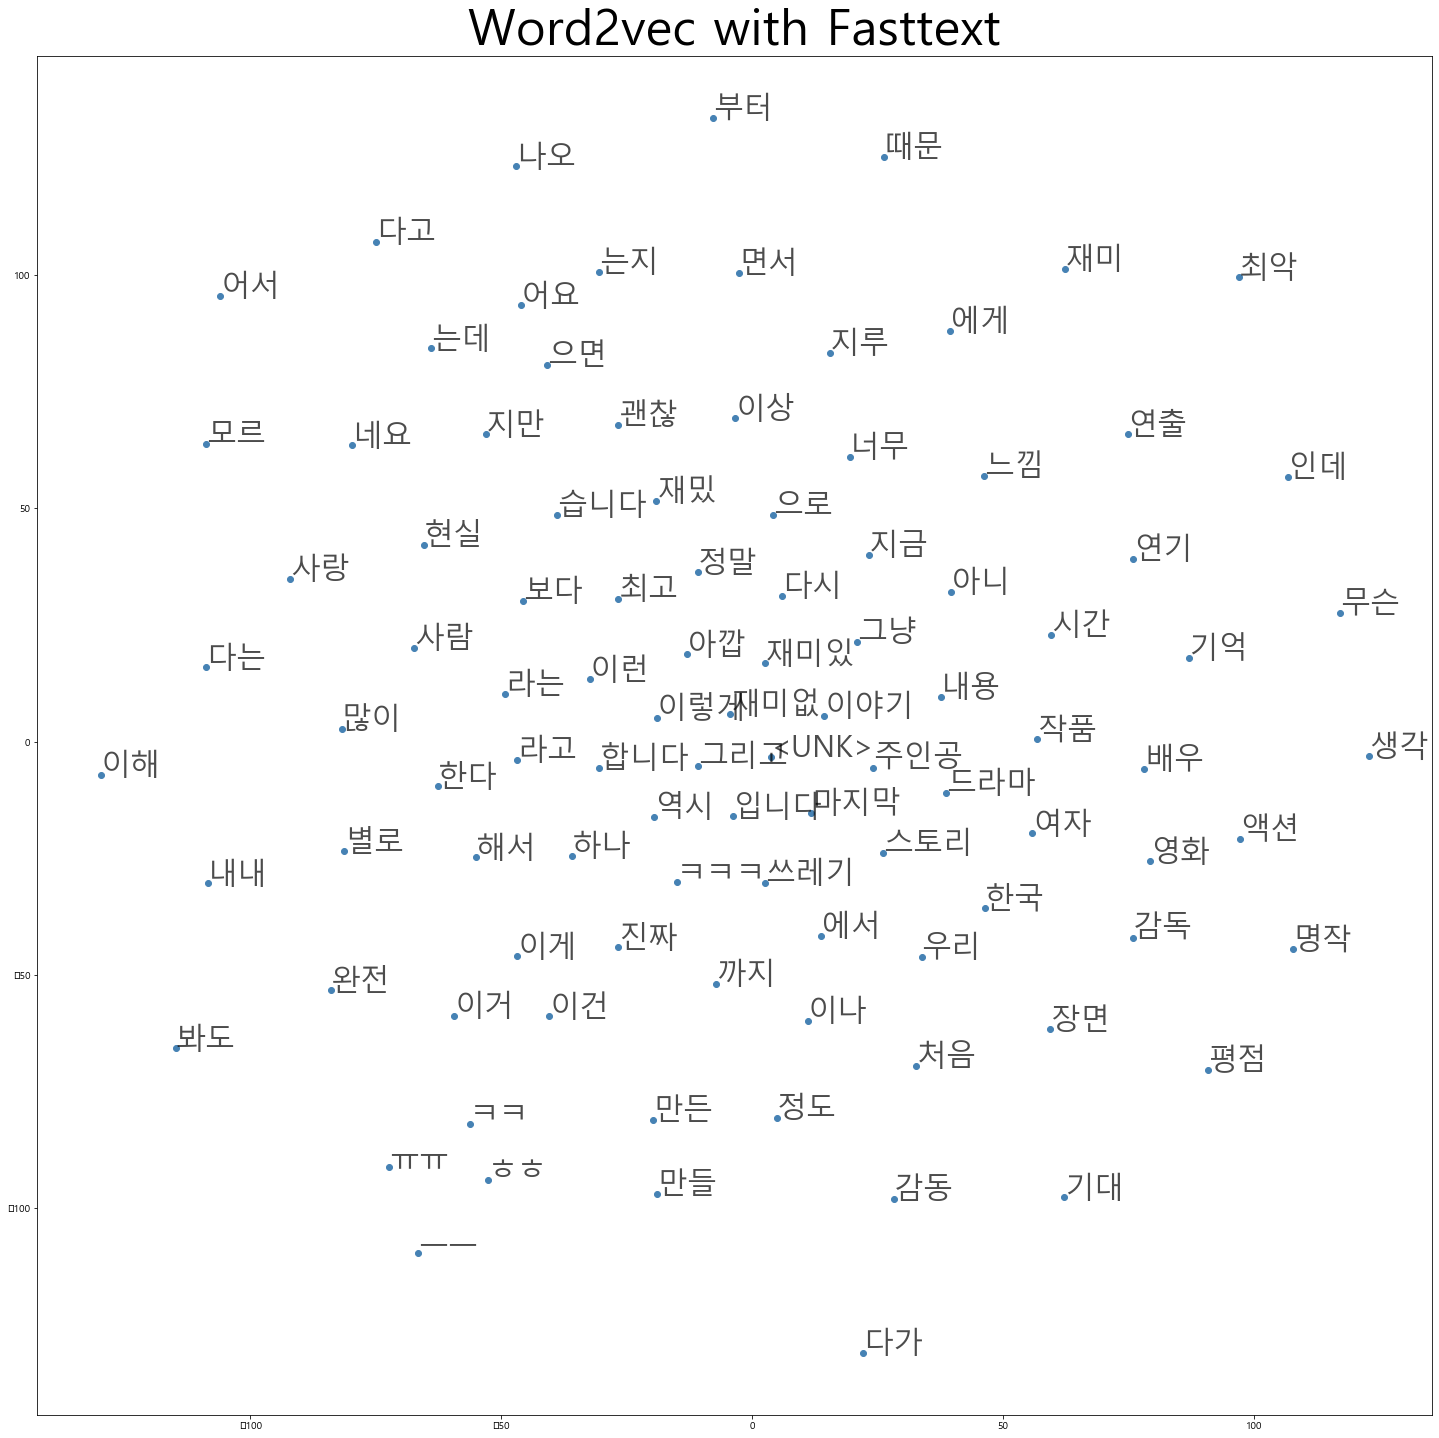

In [308]:
fig, ax = plt.subplots(figsize=(25, 25))
plt.rc('font', family='Malgun Gothic')
plt.title('Word2vec with Fasttext',{'fontsize':50})
plt.scatter(embed_tsne_plot["x"],embed_tsne_plot["y"], color='steelblue' )
for idx in range(visualize_size):    
    plt.annotate(idx2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]),fontsize=30, alpha=0.7)
plt.show()

In [393]:
from sklearn.manifold import TSNE

tsne = TSNE(3)

In [394]:
visualize_size = len(idx2word[:100])
words = idx2word[:visualize_size]

fasttext_emb =[]
for w in words:
    fasttext_emb.append(ko_model.wv[w])
fasttext_emb = np.array(fasttext_emb)

In [395]:
embed_tsne = tsne.fit_transform(fasttext_emb)

In [396]:
embed_tsne_plot =pd.DataFrame(embed_tsne, columns =["x","y","z"])

In [397]:
x,y,z =embed_tsne_plot['x'],embed_tsne_plot['y'],embed_tsne_plot['z']

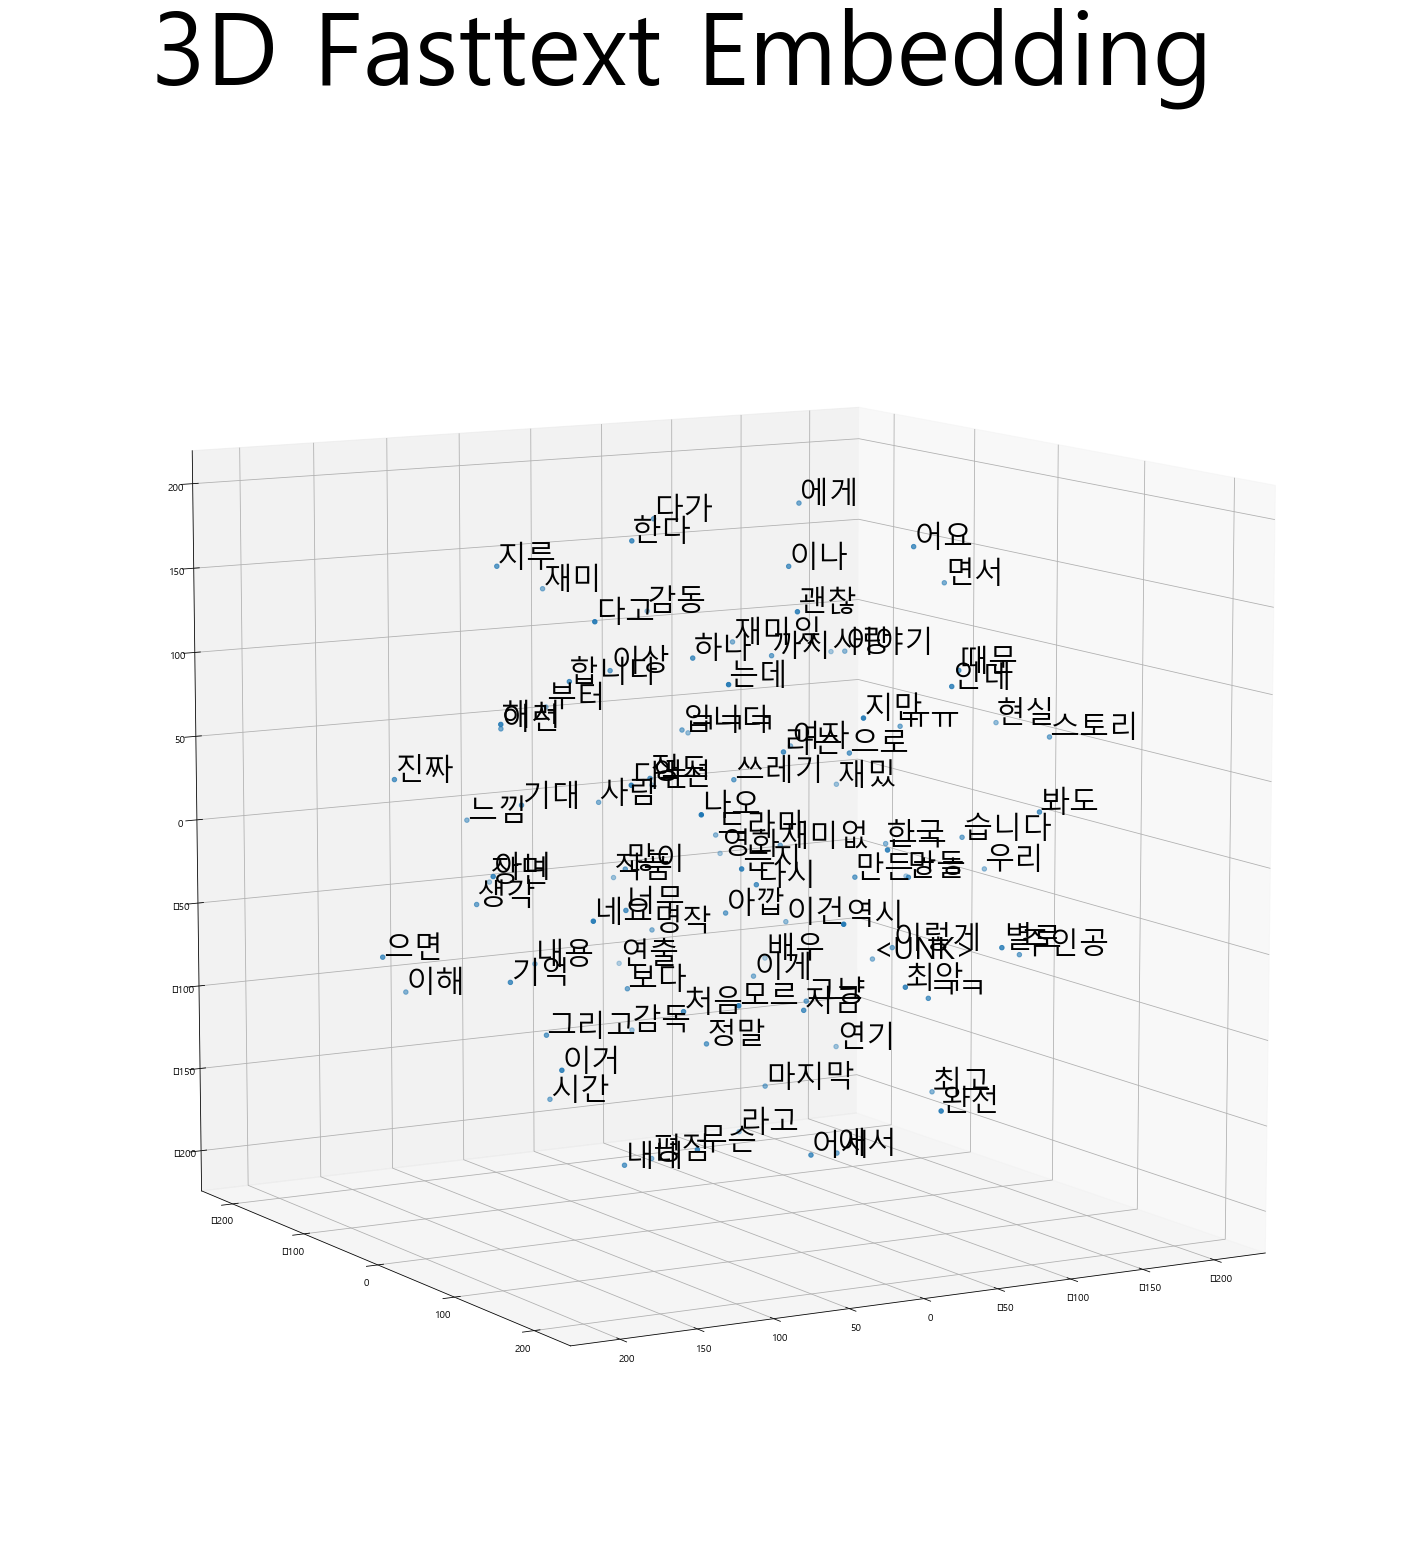

In [405]:
fig = plt.figure(figsize = [25,25])
ax = fig.gca(projection ='3d')
ax.scatter(x,y,z)

ax.view_init(10,60)
for idx, (xi, yi, zi) in enumerate(zip(x, y, z)):
    label = idx2word[idx]
    ax.text(xi, yi, zi, label,fontsize = 30)

plt.suptitle('3D Fasttext Embedding',size = 100)
plt.show()